In [1]:
import numpy as np
from ModelTest import *
import pandas as pd
from Utilities import obsFrac, getMidnightNoonIdx
from SSMTools import *
import datetime

In [2]:
colors = 2*[c["color"] for c in plt.rcParams["axes.prop_cycle"]]

# Feather River
#### Todo
* Try plotting speed of sound in air as a function of relative humidity and temperature
* Check whether the oscillations occur exactly daily

In [6]:
# Info on what's available
feather_wsns = ["ktl", "grzl"]

# Choose a network
df_feather_ktl = pd.read_csv("../output/feather/%s.csv" % feather_wsns[0])

times = pd.to_datetime(df_feather_ktl["time"])

(736437.4166666666, 736442.625)

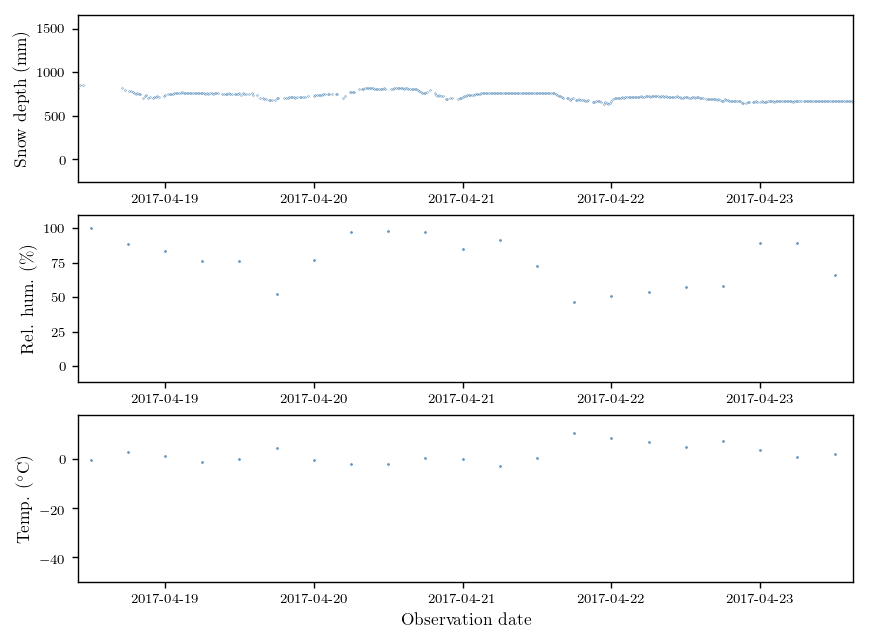

In [28]:
plt.figure(figsize=(8, 6))

sensor = 1

idx_ti = 28000#15000
ti = times[idx_ti]
tf = times[idx_ti + 500]

plt.subplot(3, 1, 1)
plt.plot(times, df_feather_ktl["snowdepth_%i"%sensor], '.', markersize=0.5)
plt.ylabel("Snow depth (mm)")
plt.xlim(ti, tf)

plt.subplot(3, 1, 2)
plt.plot(times, df_feather_ktl["rel_humidity_%i"%sensor], '.', markersize=1)
plt.ylabel("Rel. hum. (\%)")
plt.xlim(ti, tf)

plt.subplot(3, 1, 3)
plt.plot(times, df_feather_ktl["air_temp_%i"%sensor], '.', markersize=1)
plt.xlabel("Observation date")
plt.ylabel(r"Temp. ($^\circ$C)")
plt.xlim(ti, tf)

# Looking at original data provided by Eric

In [32]:
df_cleaned = loadAndClean("../output/site_1_cleaned_T.csv", toDrop=['snowdepth_2', 'snowdepth_10', 'Unnamed: 0', 'Unnamed: 0.1', 'datetime'])
for i in range(1, 11):
    df_cleaned.drop('temperature_%i'%i, axis=1, inplace=True)
fullData = df_cleaned.values

Utilities.py:238: RuntimeWarning: invalid value encountered in greater
  new_obs[mod_z>threshold] = np.nan # set outliers to NaN


In [65]:
N = fullData.shape[1]

In [33]:
df_temp = pd.read_csv("../output/site_1_cleaned_T.csv").drop(['temperature_2', 'temperature_10', 'Unnamed: 0', 'Unnamed: 0.1', 'datetime'], axis=1)
for i in range(1, 11):
    df_temp.drop('snowdepth_%i'%i, axis=1, inplace=True)
tempData = df_temp.values

In [34]:
dateTimes = pd.read_csv("../output/site_1_cleaned_T.csv").drop(['Unnamed: 0', 'Unnamed: 0.1']
                                                               + ["snowdepth_%i"%i for i in range(1, 11)]
                                                               + ["temperature_%i"%i for i in range(1, 11)], axis=1).values.flatten()

## Examining noise before first snowstorm of the year

In [104]:
ti_summer = 1700
tf_summer = 2100

(1700, 2100)

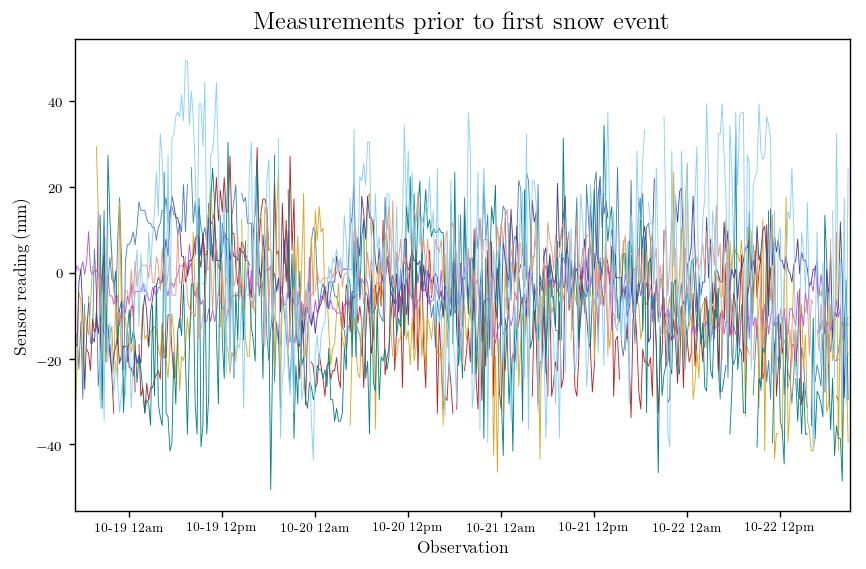

In [105]:
plt.figure(figsize=(8, 5))
plt.plot(range(ti_summer, tf_summer), fullData[ti_summer:tf_summer, :], linewidth=0.5)

plt.title("Measurements prior to first snow event")
plt.xlabel("Observation")
plt.ylabel("Sensor reading (mm)")

# Ticks at midnight and noon
xticks, xlabels = getMidnightNoonIdx(dateTimes, ti_summer, tf_summer)
plt.xticks(xticks, xlabels, fontsize=7)
plt.xlim(ti_summer, tf_summer)

### Histogram summer measurements

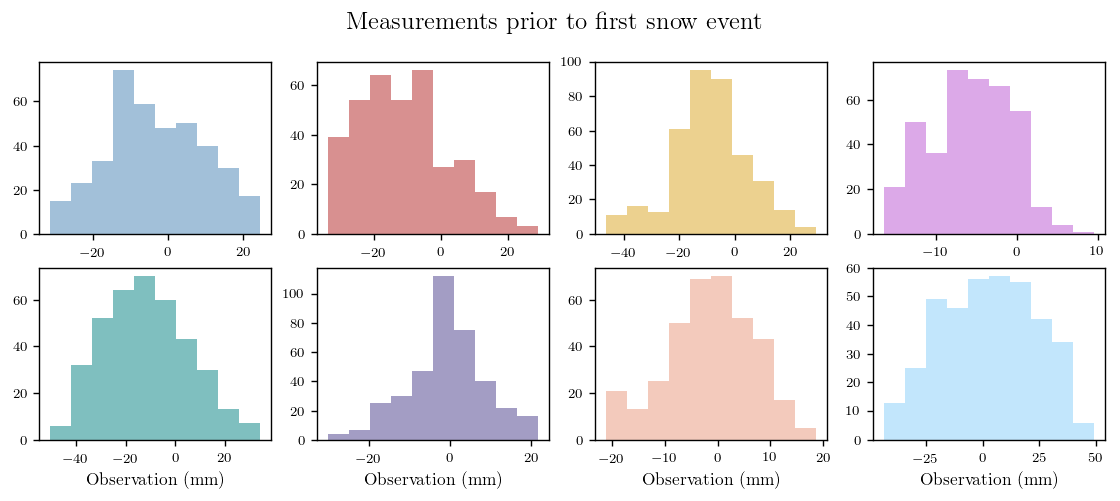

In [106]:
plt.figure(figsize=(11, 4))

subplot_cols = N / 2

for i in range(2):
    for j in range(subplot_cols):
        plt.subplot(2, subplot_cols, subplot_cols*i+j+1)
        
        series = fullData[ti_summer:tf_summer, :].T[subplot_cols*i+j]
        # Ignore nans
        plt.hist(series[~np.isnan(series)], alpha=0.5, color=colors[subplot_cols*i+j])
        
        if i == 1:
            plt.xlabel("Observation (mm)")
            
plt.suptitle("Measurements prior to first snow event")

### Compute covariance between the time series

In [107]:
cov_summer = np.zeros(2*[N])

for i in range(N):
    # Compute {y_{i,t} - E[y_i]}
    y_is = fullData[ti_summer:tf_summer, i]
    residuals_is = y_is - np.nanmean(y_is)
    
    for j in range(N):
        # Compute {y_{j,t} - E[y_j]}
        y_js = fullData[ti_summer:tf_summer, j]
        residuals_js = y_js - np.nanmean(y_js)
        
        # Times at which {y_{i,t}} and {y_{j,t}} are both non-nan
        obs_indices = np.all([~np.isnan(y_is), ~np.isnan(y_js)], axis=0)
        
        cov_summer[i, j] = np.mean(residuals_is[obs_indices] * residuals_js[obs_indices]) * len(obs_indices) / (len(obs_indices) - 1.0)

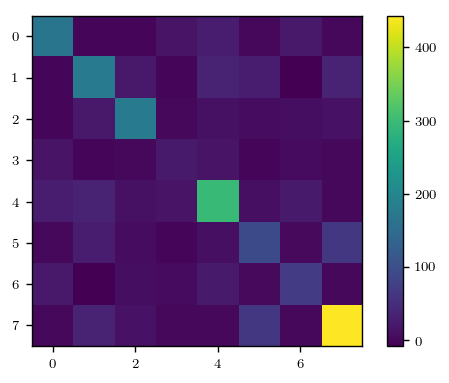

In [100]:
plt.imshow(cov_summer)
plt.colorbar()

## Histogram of gap sizes

In [6]:
genChunkTestSets(fullData, 100, 200, 20, dirName="test_data/intervalLen_200_gapSize_20/")

In [7]:
gapSizes = []

tStart = 4000

for series in fullData.T:
    curGapSizes = []
    
    curGapSize = 0
    # Loop over values in series
    for v in series[tStart:]:
        if np.isnan(v):
            curGapSize = curGapSize + 1
        elif curGapSize > 0:
            # Append current gap size if it's nonzero and a non-nan value was encountered
            gapSizes.append(curGapSize)
            curGapSize = 0
    
# Get total list of gap sizes for the whole dataset
gapSizes = np.asarray(gapSizes)

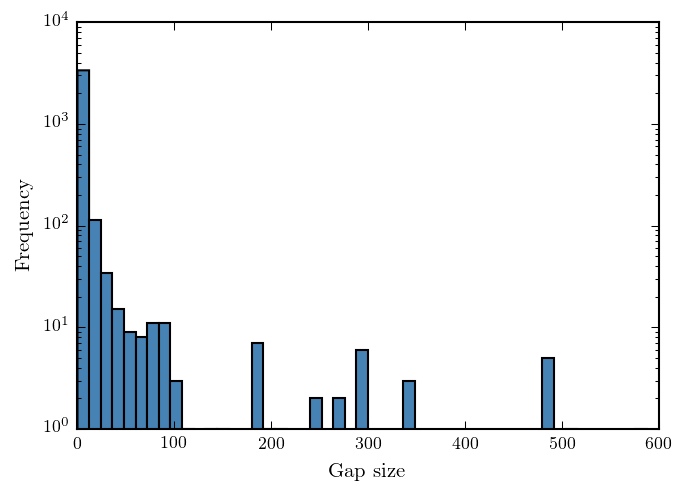

In [8]:
plt.hist(gapSizes, bins=50, range=[0, 600])
plt.yscale("log")
plt.xlabel("Gap size")
plt.ylabel("Frequency")